# Modelo SARIMAX
En este notebook probaremos a predecir las importaciones de cítricos con un modelo SARIMAX.

## Carga de los datos y selección del producto o el partner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [3]:
df = pd.read_csv('./Countries_citricos_completos/Germany.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Mes'] = df['Date'].dt.month
# Limones
df = df.loc[df['Product'] == 'Fresh or dried lemons', :]

df = df.groupby(['Date'], as_index=False).agg({
    'kg': 'sum', 
    **{col: 'first' for col in df.columns if col not in ['Date', 'kg', 'Partner', 'Member State']}
})
df = df.sort_values('Date', ascending=True).reset_index(drop=True)
df

,Date,kg,Product,Euro Value,Unit Value,Año,Precipitación,Temperatura,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),...,Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita,Mes
0,2014-10-01,19790.0,Fresh or dried lemons,21491.94,1.086000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
1,2014-10-06,56574.0,Fresh or dried lemons,170.00,1.700000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
2,2014-10-13,96419.0,Fresh or dried lemons,255.00,1.700000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
3,2014-10-20,48970.0,Fresh or dried lemons,1585.50,0.556316,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
4,2014-10-27,83059.0,Fresh or dried lemons,142.50,1.900000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2024-10-07,6.5,Fresh or dried lemons,10.00,10.000000,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10
506,2024-10-14,4074.0,Fresh or dried lemons,81.00,40.500000,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10
507,2024-10-21,4882.1,Fresh or dried lemons,2772.00,2.613122,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10
508,2024-10-28,201.6,Fresh or dried lemons,80.00,0.400000,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10


In [5]:
f = df.drop(['Product','Date', 'Euro Value', 'Unit Value', 'Mes', 'Año'], axis=1)
correlaciones = f.corr()
print(correlaciones['kg'].sort_values(ascending=False))

kg                                    1.000000
Temperatura                           0.554414
Precipitación                         0.145089
Masc. Adultos medios (35-54 años)     0.090887
Masc. Adultos jóvenes (20-34 años)    0.038288
PIB per capita                        0.033515
Masc. Ancianos (75+ años)             0.032151
Fem. Ancianos (75+ años)              0.024817
Masc. Adultos mayores (55-74 años)   -0.013457
Fem. Adultos mayores (55-74 años)    -0.024631
Fem. Adultos jóvenes (20-34 años)    -0.040810
Fem. Adultos medios (35-54 años)     -0.044453
Masc. Niños (5-14 años)              -0.070934
Fem. Niños (5-14 años)               -0.072992
Masc. Adolescentes (15-19 años)      -0.075393
Fem. Adolescentes (15-19 años)       -0.086043
Name: kg, dtype: float64


## Predicciones de temperatura y precipitación
Aquí generamos los datos de temperatura y precipitación a un año vista, asumiendo que el clima no va a cambiar mucho, añadiendo algo de ruido sobre los valores de años anteriores. 

In [59]:
# Seleccionamos las variables climáticas
df_clima = df.copy()
df_clima = df_clima[['Mes','Año','Temperatura','Precipitación']]

# Creamos un dataframe para las previsiones a 1 año vista
df_prevision_clima = pd.DataFrame({'Mes':[10,11,12,1,2,3,4,5,6,7,8,9,10],'Año':[2024,2024,2024,2025,2025,2025,2025,2025,2025,2025,2025,2025,2025],
                             'Temperatura':13*np.nan, 'Precipitación':13*np.nan})

# Calculamos las medias de cada mes durante los años disponibles
medias_temperatura = df_clima.groupby('Mes')['Temperatura'].mean()
medias_precipitacion = df_clima.groupby('Mes')['Precipitación'].mean()

# Asignamos las medias a las previsiones
df_prevision_clima['Temperatura'] = df_prevision_clima['Mes'].map(medias_temperatura)
df_prevision_clima['Precipitación'] = df_prevision_clima['Mes'].map(medias_precipitacion)
display(df_prevision_clima)


,Mes,Año,Temperatura,Precipitación
0,10,2024,11.842093,64.709667
1,11,2024,6.779093,59.528674
2,12,2024,3.526628,67.997442
3,1,2025,2.074244,68.816311
4,2,2025,2.966366,56.060707
5,3,2025,5.795676,49.900000
6,4,2025,9.193812,47.752156
7,5,2025,13.487390,63.426537
8,6,2025,18.016262,74.698762
9,7,2025,19.342267,77.150911


In [63]:
df_prevision_clima['ds'] = pd.to_datetime(df_prevision_clima['Año'].astype(str) + '-' + df_prevision_clima['Mes'].astype(str) + '-01')
df_prevision_clima = df_prevision_clima.set_index('ds')

# Propagar los valores mensuales a frecuencia semanal
datos_climaticos_semanal = df_prevision_clima.resample('W').ffill().reset_index()
datos_climaticos_semanal.drop(['Mes','Año'], axis=1, inplace=True)
datos_climaticos_semanal['ds'] = datos_climaticos_semanal['ds'] + pd.Timedelta(days=1)

ultima_fila = datos_climaticos_semanal.iloc[-1]

nuevas_fechas = [
    ultima_fila['ds'] + pd.Timedelta(weeks=i) 
    for i in range(1, 4)
]

nuevas_filas = pd.DataFrame([ultima_fila] * 3)
nuevas_filas['ds'] = nuevas_fechas

datos_climaticos_semanal = pd.concat([datos_climaticos_semanal, nuevas_filas], ignore_index=True)
datos_climaticos_semanal = datos_climaticos_semanal.iloc[5:]
datos_climaticos_semanal.drop(columns=['ds'], inplace=True)
display(datos_climaticos_semanal.tail(6))


,Temperatura,Precipitación
50,15.602929,62.392238
51,15.602929,62.392238
52,11.842093,64.709667
53,11.842093,64.709667
54,11.842093,64.709667
55,11.842093,64.709667


## Predicciones demográficas y de PIB per capita
Aquí vamos a predecir los valores anuales de las variables demográficas y de PIB per capita. Haremos uso de un modelo de regresión lineal.

In [66]:
df_demo = df.copy()
df_demo = df_demo[['Año','Fem. Niños (5-14 años)',
       'Fem. Adolescentes (15-19 años)', 'Fem. Adultos jóvenes (20-34 años)',
       'Fem. Adultos medios (35-54 años)', 'Fem. Adultos mayores (55-74 años)',
       'Fem. Ancianos (75+ años)', 'Masc. Niños (5-14 años)',
       'Masc. Adolescentes (15-19 años)', 'Masc. Adultos jóvenes (20-34 años)',
       'Masc. Adultos medios (35-54 años)',
       'Masc. Adultos mayores (55-74 años)', 'Masc. Ancianos (75+ años)',
       'PIB per capita']]

df_prevision_demo = pd.DataFrame({
    'Año': [2025]
})

datos_anuales = df_demo.groupby('Año').mean().reset_index()


In [67]:
variables = datos_anuales.columns.difference(['Año'])

for variable in variables:
    X = datos_anuales[['Año']]
    y = datos_anuales[variable]

    modelo = LinearRegression()
    modelo.fit(X, y)

    df_prevision_demo[variable] = modelo.predict(df_prevision_demo[['Año']])

df_prevision_demo_final = pd.concat([datos_anuales, df_prevision_demo], axis=0).reset_index(drop=True)
df_prevision_demo_final = df_prevision_demo_final.round(0)

prevision_demo = df_prevision_demo_final.loc[df_prevision_demo_final['Año'].isin([2024,2025]), :]
display(prevision_demo)

,Año,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),Fem. Adultos jóvenes (20-34 años),Fem. Adultos medios (35-54 años),Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita
10,2024,4011538.0,1944184.0,7367148.0,10882739.0,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0
11,2025,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0


In [72]:
fechas = datos_climaticos_semanal['ds']
datos_demo_semanal = pd.DataFrame({'ds': fechas})
datos_demo_semanal['Año'] = pd.to_datetime(datos_demo_semanal['ds']).dt.year

datos_demo_semanal = datos_demo_semanal.merge(prevision_demo, on='Año', how='left')
datos_demo_semanal = datos_demo_semanal.drop('Año', axis=1)
display(datos_demo_semanal.tail(3))

,ds,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),Fem. Adultos jóvenes (20-34 años),Fem. Adultos medios (35-54 años),Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita
48,2025-10-13,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0
49,2025-10-20,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0
50,2025-10-27,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0


## SARIMAX

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

In [27]:
df_sarima = df.copy()
df_sarima['Date'] = pd.to_datetime(df_sarima['Date'])
df_sarima = df_sarima.rename(columns={'kg': 'y'})
df_sarima.set_index('Date', inplace=True)

In [44]:
df_sarima = df_sarima[df_sarima['y'] < 600000]

In [48]:
# Configuración de la validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)  # Número de divisiones
rmse_scores = []
r2_scores = []
models = []

# Bucle de validación cruzada
for train_index, test_index in tscv.split(df_sarima):
    # Dividir los datos en entrenamiento y prueba
    train = df_sarima.iloc[train_index]
    test = df_sarima.iloc[test_index]

    train_y = train['y']
    train_exog = train[['Temperatura', 'Precipitación']] 
    test_exog = test[['Temperatura', 'Precipitación']] 
    
    # Ajustar el modelo SARIMAX utilizando auto_arima
    auto_model = auto_arima(
        train_y, 
        exogenous=train_exog,
        seasonal=True, 
        m=52,  # Estacionalidad semanal
        trace=True,  
        error_action='ignore', 
        suppress_warnings=True
    )
    
    # Entrenar el modelo SARIMAX con los parámetros encontrados por auto_arima
    model = SARIMAX(train_y, exog=train_exog, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    results = model.fit()

    # Guardar el modelo entrenado
    models.append((auto_model.order, auto_model.seasonal_order, results))
    
    # Predecir en el conjunto de prueba
    predicciones_test = results.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)
    
    # Calcular métricas de evaluación
    rmse = root_mean_squared_error(test['y'], predicciones_test)
    r2 = r2_score(test['y'], predicciones_test)
    
    # Guardar las métricas
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Mostrar los resultados de la validación cruzada
print(f'RMSE promedio: {np.mean(rmse_scores)}')
print(f'R2 promedio: {np.mean(r2_scores)}')
print(f'RMSE en cada fold: {rmse_scores}')
print(f'R2 en cada fold: {r2_scores}')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3153.252, Time=2.00 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3275.826, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3178.325, Time=0.65 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3233.175, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3329.368, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3151.437, Time=0.76 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3151.184, Time=0.03 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=3151.357, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3151.023, Time=0.01 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3150.312, Time=1.76 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=3151.074, Time=4.28 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=3152.270, Time=0.91 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=3150.509, Time=0.53 sec
 ARIMA(2,0,1)(2,0,1)[52]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.22409D+01    |proj g|=  1.47472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      8      1     0     0   1.561D-05   1.224D+01
  F =   12.240942657330468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=6.75 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6593.001, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6431.922, Time=0.57 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6517.092, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6694.151, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6429.924, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=6431.924, Time=1.06 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=6433.914, Time=1.31 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=6406.320, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=6408.144, Time=0.80 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=6408.191, Time=1.02 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=6409.785, Time=1.68 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=6405.392, Time=0.03 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=6407.205, Time=1.06 sec
 ARIMA(3,0,0)(0,0,1)[52]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25813D+01    |proj g|=  2.46251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4      7      1     0     0   8.307D-06   1.258D+01
  F =   12.581314906587844     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=9570.123, Time=8.84 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=9878.769, Time=0.01 sec
 ARIMA(1,0,0)(1,0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25753D+01    |proj g|=  1.23906D-01

At iterate    5    f=  1.25637D+01    |proj g|=  3.55934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7     10      1     0     0   5.779D-06   1.256D+01
  F =   12.563652835709958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE promedio: 92737.19150753267
R2 promedio: 0.29913247489330447
RMSE en cada fold: [102597.54199457227, 84487.83589046133, 91126.19663756441]
R2 en cada fold: [0.25119984342270396, 0.4200619346964328, 0.22613564656077667]


In [55]:
modelo_elegido = models[1]  
order_elegido, seasonal_order_elegido, modelo_entrenado = modelo_elegido
print(f'Modelo seleccionado: order={order_elegido}, seasonal_order={seasonal_order_elegido}')

Modelo seleccionado: order=(3, 0, 0), seasonal_order=(0, 0, 0, 52)


In [56]:
# Reentrenar el modelo seleccionado con todos los datos
modelo_final = SARIMAX(df_sarima['y'], exog=df_sarima[['Temperatura','Precipitación']], order=order_elegido, seasonal_order=seasonal_order_elegido)
resultados_finales = modelo_final.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25910D+01    |proj g|=  1.37499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4      6      1     0     0   3.237D-05   1.259D+01
  F =   12.591017822654754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [66]:
# Predecir 1 año a futuro (365 días)
predicciones_futuras = resultados_finales.forecast(steps=51, exog= datos_climaticos_semanal)

# Crear un índice de fechas para las predicciones futuras
indice_futuro = pd.date_range(start=df_sarima.index[-1] + pd.Timedelta(days=1), periods=51, freq='W')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


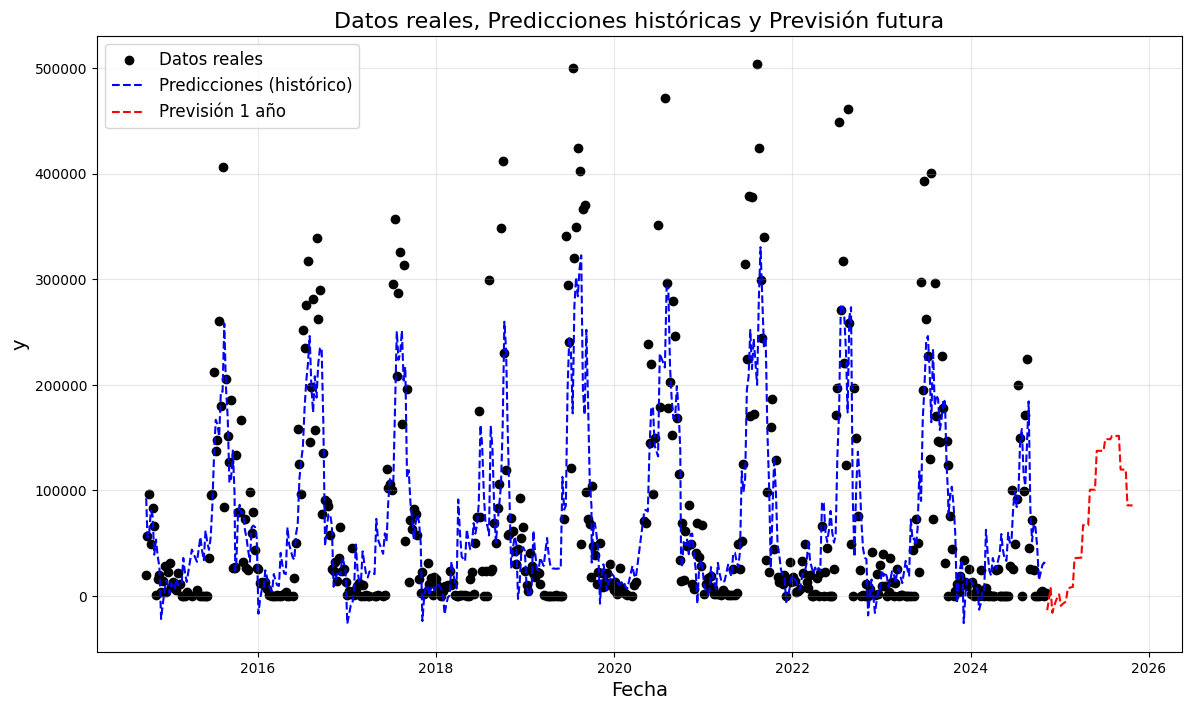

In [67]:
# Graficar los resultados
plt.figure(figsize=(14, 8))

# Datos reales
plt.scatter(df_sarima.index, df_sarima['y'], label='Datos reales', color='black', linewidth=1)

# Predicciones del modelo en el histórico
predicciones_historicas = resultados_finales.predict(start=0, end=len(df_sarima) - 1)
plt.plot(df_sarima.index, predicciones_historicas, label='Predicciones (histórico)', color='blue', linestyle='--')

# Predicciones futuras (1 año)
plt.plot(indice_futuro, predicciones_futuras, label='Previsión 1 año', color='red', linestyle='--')

# Detalles del gráfico
plt.title('Datos reales, Predicciones históricas y Previsión futura', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Resultados
**Con 'y' < 600000**

*Sin regresores*:

RMSE: 80570.2

R2: 0.4

*Con regresores climáticos*:

RMSE: 84447.8

R2: 0.42

*Con regresores demográficos*:

RMSE:

R2:

Con regresores climáticos y demográficos:

